In [1]:
# PyTorch is a common library for neural networks in Python. torch.nn is a module for building layers of Neural Networks.
import torch
from torch import nn
import torch.nn.functional as F

# TorchVision is part of the PyTorch environment. It is necessary to download the datasets MNIST (and EMNIST Letters)
import torchvision
import torchvision.transforms as transforms

# Usual mathematical stuff
import numpy as np
import math
# Plots
import matplotlib.pyplot as plt

# Timing
import time
from datetime import datetime
import time

# additional packages
import torchvision.utils as vutils
# from torchviz import make_dot

In [2]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [36]:
device = chooseDevice()

GPU not available, CPU available


In [3]:
_ = torch.manual_seed(2472) 

In [4]:
# Extracts the train and test sets from a chosen image dataset
# Values of pixels are normalized between -1 and 1

def getData(dataset = "MNIST", info = True):
    if dataset == "MNIST":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.MNIST(root=".", train=False, download=True, transform=transform)
    elif dataset == "EMNIST_Letters":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = torchvision.datasets.EMNIST(root=".", split="letters", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.EMNIST(root=".", split="letters", train=False, download=True, transform=transform)
    else:
        print("DATASET NOT CORRECTLY DEFINED")
    if info:
        print(train_set)
        print(test_set)
    return train_set, test_set

In [5]:
# Choose which dataset to use

dataset = "MNIST"
#dataset = "EMNIST_Letters"

train_set, test_set = getData(dataset = dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [6]:
# Get information about the size of the train and test sets.

def dataSize(train_set, test_set):
    n_train_set = train_set.__len__()
    n_test_set = test_set.__len__()
    n_tot = n_train_set + n_test_set
    ratio_train_test = n_train_set / n_test_set
    percentage_train = n_train_set / n_tot
    percentage_test = 1.0 - percentage_train
    return n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test

In [7]:
n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test = dataSize(train_set, test_set)

In [58]:
# Paramater for the batch size
# Predefined value = 32

batch_size = 32

In [9]:
# Divide dataset into batches

def divideInBatches(train_set, test_set, batch_size, n_train_set, n_test_set):
    # Train set
    n_batches_total = math.ceil(n_train_set/batch_size)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
    # Test set
    n_batches_total_test = math.ceil(n_test_set/batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader, n_batches_total, n_batches_total_test

In [10]:
train_loader, test_loader, n_batches_total, n_batches_total_test = divideInBatches(train_set, test_set, batch_size, n_train_set, n_test_set)

In [11]:
# Corrects EMNIST Letters data

def correctData(real_samples, mnist_labels, dataset):
    if dataset == "EMNIST_Letters":
        real_samples = torch.transpose(real_samples,2,3)
        mnist_labels -= 1
    return real_samples, mnist_labels

In [12]:
real_samples, mnist_labels = next(iter(train_loader))
real_samples, mnist_labels = correctData(real_samples, mnist_labels, dataset)

In [39]:
# Plot digits or letters

def showImages(samples, true_labels = None, predicted_labels = None, generated = False, predicted = False, epoch = None):
    
    if generated == True and predicted == True:
        plt.close("Generated predicted samples")
        f = plt.figure("Generated predicted samples", figsize = (20,15))
        f.suptitle("Generated predicted samples", fontsize = 30)
    elif generated == True and predicted == False :
        if epoch != None:
            plt.close("Generated samples epoch " + str(epoch))
            f = plt.figure("Generated samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Generated samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Generated samples")
            f = plt.figure("Generated samples", figsize = (20,15))
            f.suptitle("Generated samples", fontsize = 30)            
    elif predicted == True and generated == False :
        if epoch != None:
            plt.close("Predicted samples epoch " + str(epoch))
            f = plt.figure("Predicted samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Predicted samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Predicted samples")
            f = plt.figure("Predicted samples", figsize = (20,15))
            f.suptitle("Predicted samples", fontsize = 30)            
    else:
        plt.close("MNIST samples")
        f = plt.figure("MNIST samples", figsize = (20,15))
        f.suptitle("MNIST training samples", fontsize = 30)
    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)
    
    for i in range(16):
        if i < samples.size(0):
            if generated:
                a = samples[i][0].detach().numpy()
            else:
                a = samples[i]
            fi = f.add_subplot(4, 4, i + 1)
            fi.imshow(a.reshape(28, 28), cmap="gray_r")
            plt.xticks([])
            plt.yticks([]) 
            if generated == True and predicted == True :
                fi.title.set_text("Pred: " + str(predicted_labels[i].detach().numpy()))
            elif generated == True and predicted == False :
                fi.title.set_text("Sample " + str(i))
            elif predicted == True and generated == False :
                fi.title.set_text("Pred: " + str(predicted_labels[i].detach().numpy()) +  ", true: " + str(true_labels[i].detach().numpy()))
            else:
                fi.title.set_text("Sample " + str(i) + ": " + str(true_labels[i].detach().numpy()))
    
    now = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
    if generated == True and predicted == True :
        f.savefig('./Figures/Sample_generated__' + now + '__epoch_' + str(epoch) + '.svg')
    elif generated == True and predicted == False :
        f.savefig('./Figures/Sample_generated_predicted__' + now + '__epoch_' + str(epoch) + '.svg')
    elif predicted == True and generated == False :
        f.savefig('./Figures/Sample_predicted__' + now + '__epoch_' + str(epoch) + '.svg')
    else:
        f.savefig('./Figures/Sample_MNIST.svg')

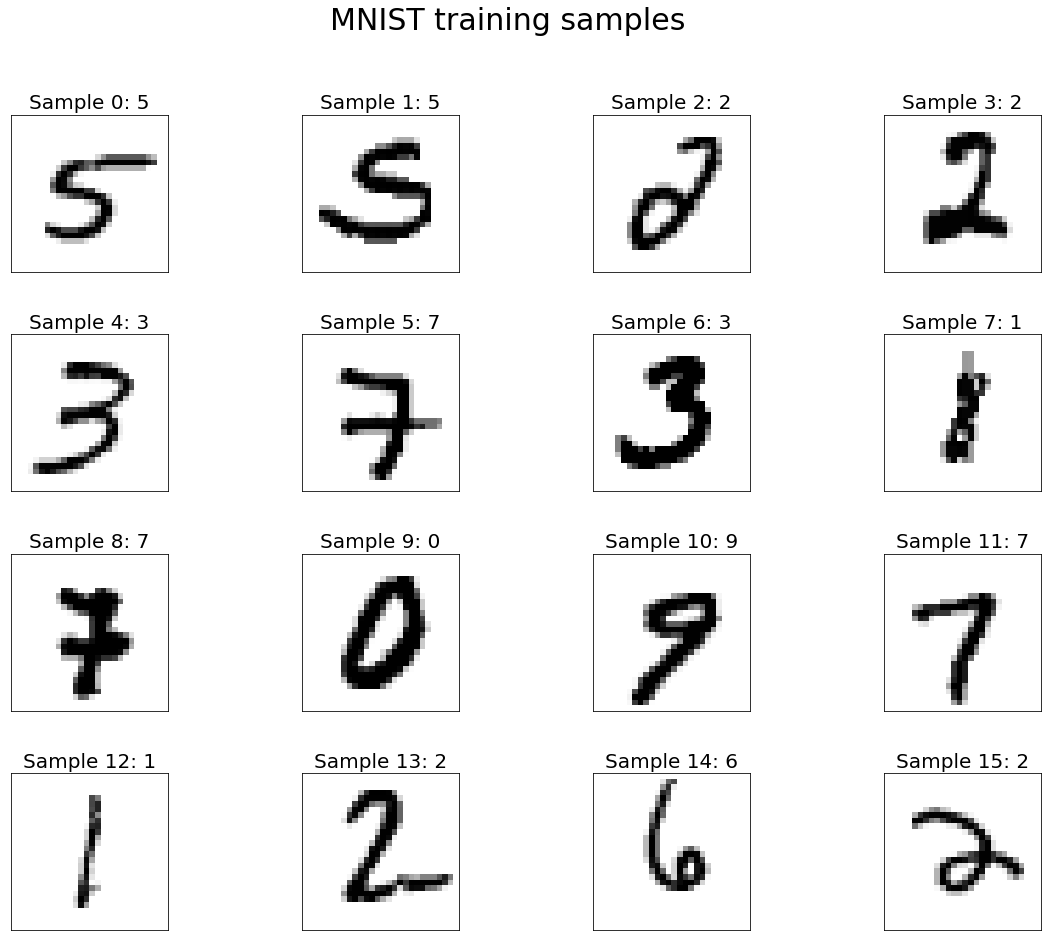

In [40]:
showImages(real_samples, true_labels = mnist_labels)

In [20]:
# Dimension of the latent space
# Predefined value = 100

dim_latent_space = 100

In [18]:

def computeGANAccuracy(y_predicted,y_true):
    
    accuracy = torch.sum((y_predicted>0) == y_true) / len(y_true)

    return accuracy

In [19]:
def generate_latent_vectors(dim_latent_space, batch_size):
    # generate latent vectors based on a standard normal distribution
    latent_vectors = torch.randn(dim_latent_space * batch_size).reshape(batch_size, dim_latent_space)

    return latent_vectors

In [17]:
fixed_noise = generate_latent_vectors(dim_latent_space, batch_size).to(device)

In [29]:
def loadModel(model, model_name, date_time):
    model.load_state_dict(torch.load('./Models/' + model_name ))
    model.eval()
    return model

In [22]:
def numberClasses(dataset):
    n_classes = len(dataset.classes)
    return n_classes

In [34]:
n_classes = numberClasses(train_set)

In [24]:
def plot_cnn_prediction(classifier, data_loader, min=0, max=5):
    for i, data in enumerate(data_loader, 0):
        if i in range(min, max):
            X = data[0].to(device)
            y_true = data[1].to(device)
            result = classifier(X)
            y_hat = classifier.predictLabels(result)[0]
            print("Saving Images: %d" % (i+1))
            showImages(X, true_labels=y_true, predicted_labels=y_hat, predicted=True)

In [31]:
class Generator(nn.Module):

    def __init__(self, dim_latent_space):
        super().__init__()
        self.dim_latent_space = dim_latent_space
        self.fc = nn.Linear(self.dim_latent_space, 64*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.trans_conv2 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.trans_conv3 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.trans_conv4 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):                   # Input = batch_size*dim_latent_space
        x = self.fc(x)                      # Output = batch_size*(64*7*7)
        x = x.view(-1, 64, 7, 7)            # Output = batch_size*64*7*7
        x = self.trans_conv1(x)             # Output = batch_size*64*14*14
        x = F.relu(self.batch_norm1(x))
        x = self.trans_conv2(x)             # Output = batch_size*32*14*14
        x = F.relu(self.batch_norm2(x))
        x = self.trans_conv3(x)             # Output = batch_size*16*14*14
        x = F.relu(self.batch_norm3(x))     
        x = self.trans_conv4(x)             # Output = batch_size*1*28*28
        x = torch.tanh(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)     
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(128*7*7, 1)
    
    def forward(self, x):                               # Input = batch_size*1*28*28
        x = x.view(-1, 1, 28, 28)                       # Output = batch_size*1*28*28
        x = F.leaky_relu(self.conv0(x), 0.2)            # Output = batch_size*32*14*14
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)            # Output = batch_size*64*14*14
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)            # Output = batch_size*128*14*14
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)            # Output = batch_size*128*7*7
        x = self.conv3_drop(x)
        x = x.view(-1, 128*7*7)                         # Output = batch_size*(128*7*7)
        x = self.fc(x)                                  # Output = batch_size*1
        return x
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),                      
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(         
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )
    
    def scaleToProbabilities(self, outmap, scale_factor = 3): 
        # scale_factor allows to scale your output before passing it into the softmax function 
        # in order to get numbers interpratble as probabilities
        
        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities
    
    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

torch.Size([32, 1, 28, 28])


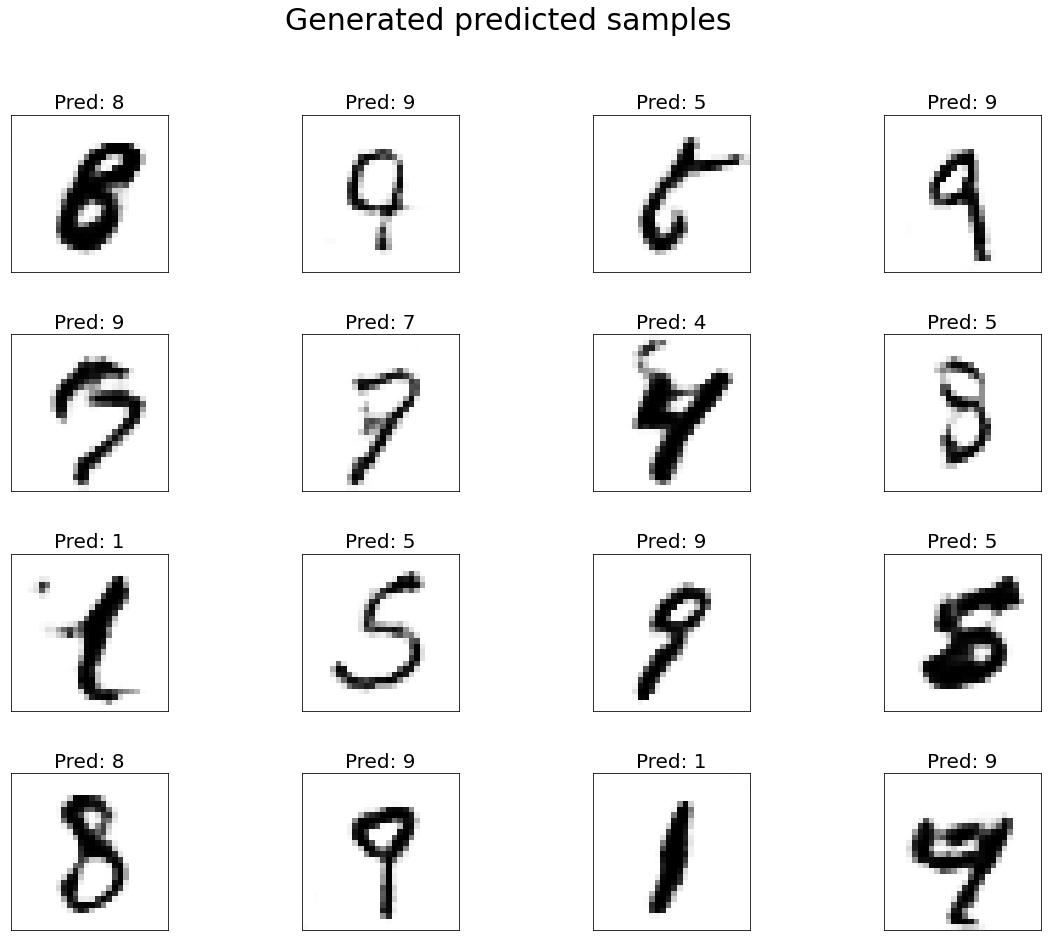

In [42]:
date_time = ""
genname = "gen7"
disname = "dis7"
cnnname = "cnn_5_epochs"
generator = Generator(dim_latent_space)
discriminator = Discriminator()
cnn = CNN(n_classes)
generator =  loadModel(generator, genname, date_time)
discriminator = loadModel(discriminator, disname, date_time)
cnn = loadModel(cnn, cnnname, date_time)



generator.eval()
cnn.eval()
latent_vectors = generate_latent_vectors(dim_latent_space, batch_size).to(device)
generated_images = generator(latent_vectors).to(device)
labels = cnn(generated_images)
pl = cnn.predictLabels(labels)[0]

print(generated_images.shape)
showImages(generated_images, generated=1, predicted_labels=pl, predicted=1, epoch=7)

### 3.1 Combine your generator and your classifier

- First step: Generation of a lot of triplets (latent vector, generated image, predicted label). To do so, you randomly generate latent vectors, which you pass in your generator to create the corresponding images, and then give the latter to you classifer to get its predicted labels.


torch.Size([32, 1, 28, 28])


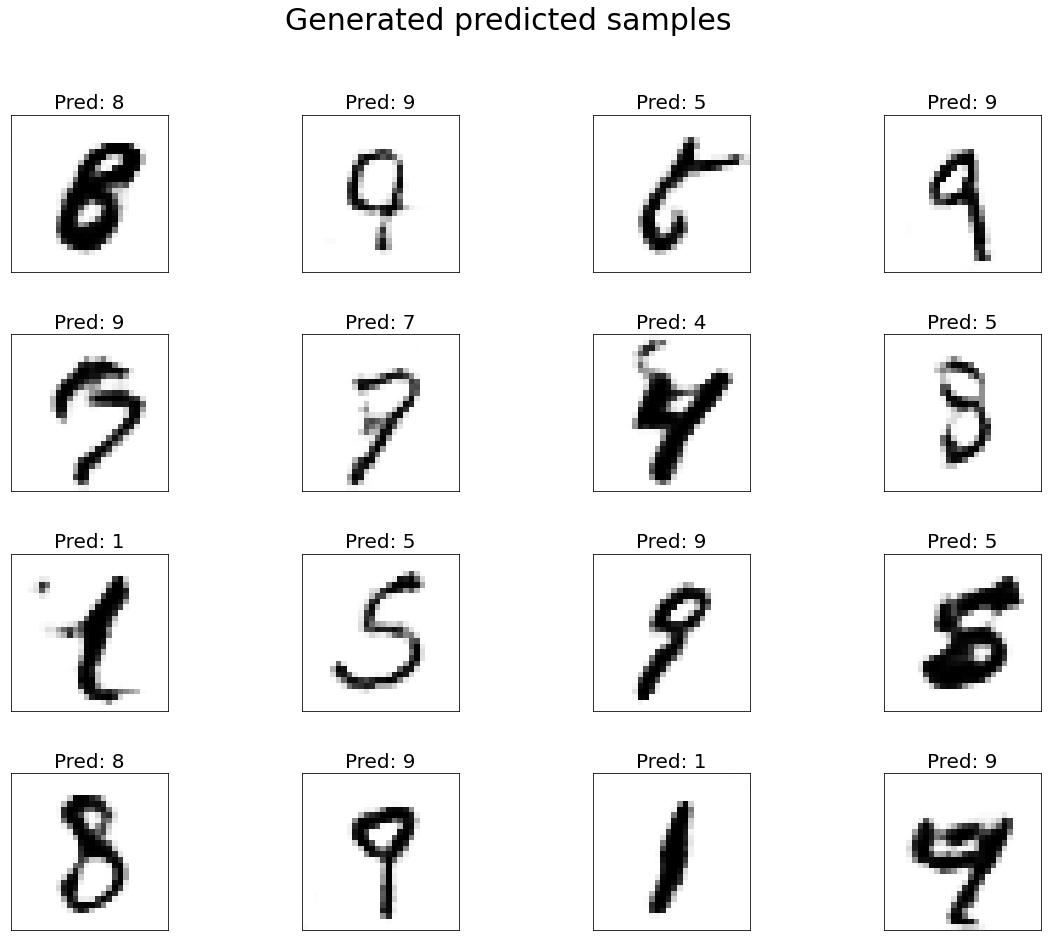

In [134]:
#now we pass rlvs_lot through the image generator
#print(rlvs_lot)--> i just wanted to check it, ignore it

date_time = ""
genname = "gen5"
disname = "dis5"
cnnname = "cnn_5_epochs"

generator = Generator(dim_latent_space)
discriminator = Discriminator()
cnn = CNN(n_classes)

#loading the generator, discriminator and cnn model (classifier)
generator =  loadModel(generator, genname, date_time)
discriminator = loadModel(discriminator, disname, date_time)
cnn = loadModel(cnn, cnnname, date_time)



generator.eval()
discriminator.eval()
cnn.eval()


torch.Size([32, 100])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10])
1552


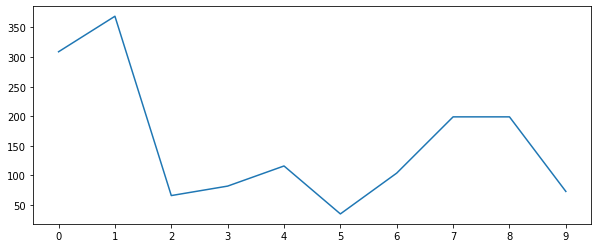

In [137]:
nb_el = 200
list_lat_vec = []
list_images = []
list_lab = []


thresh = 0.9

for i in range(nb_el):
  list_lat_vec.append(generate_latent_vectors(dim_latent_space, batch_size))
  list_images.append(generator(list_lat_vec[i]))
  list_lab.append(cnn(list_images[i]))

print(list_lat_vec[0].shape)
print(list_images[0].shape)
print(list_lab[0].shape)

flist_lat_vec = []
flist_images = []
flist_lab = []

nbnb = np.zeros(n_classes)

for i in range(nb_el):
  #  predicted_labels, probabilities, certainty
  prob = cnn.predictLabels(list_lab[i])
  # print((prob))
  for j in range(batch_size):
    if prob[2][j].item()> thresh:
      flist_lat_vec.append(list_lat_vec[i][j])
      flist_images.append(list_images[i][j])
      flist_lab.append(prob[0][j].item())
      nbnb[flist_lab[-1]] +=1
print(len(flist_lat_vec))

f = plt.figure()
f.set_figwidth(10)
ax1 = plt.subplot()
ax1.set_xticks(np.arange(n_classes))
ax1.plot(nbnb)
f.show()

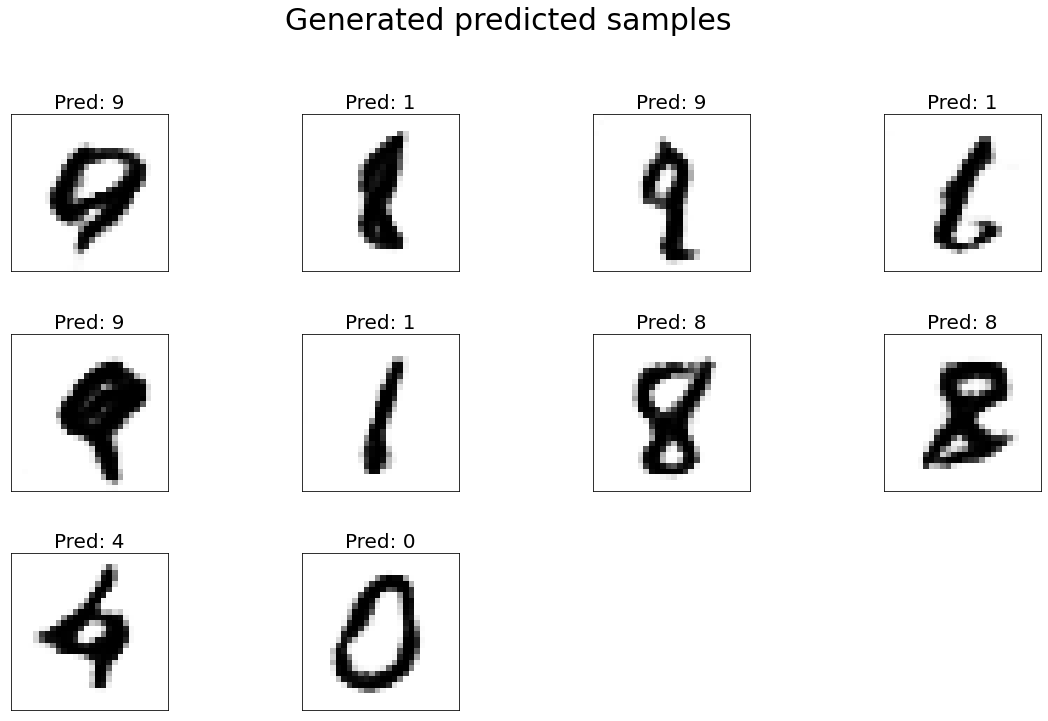

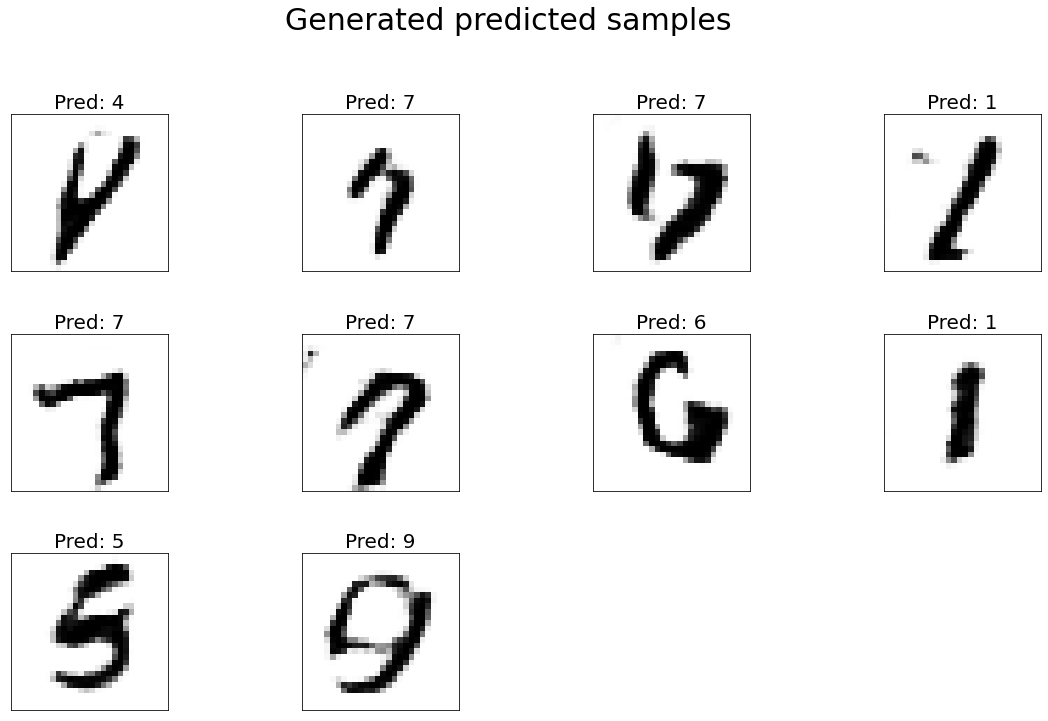

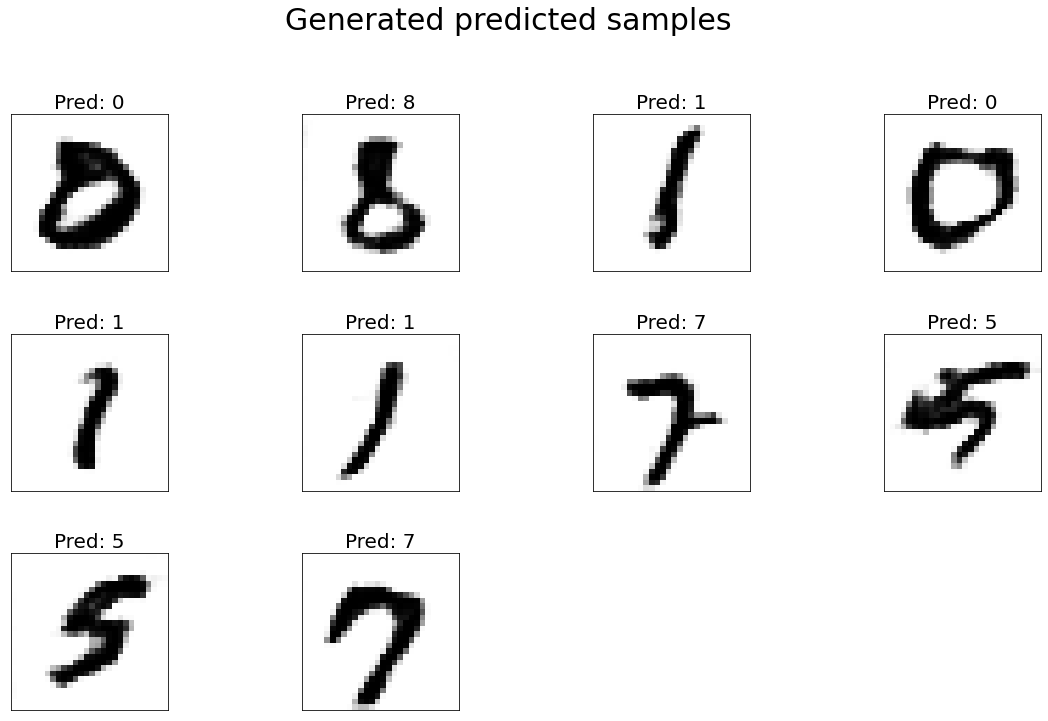

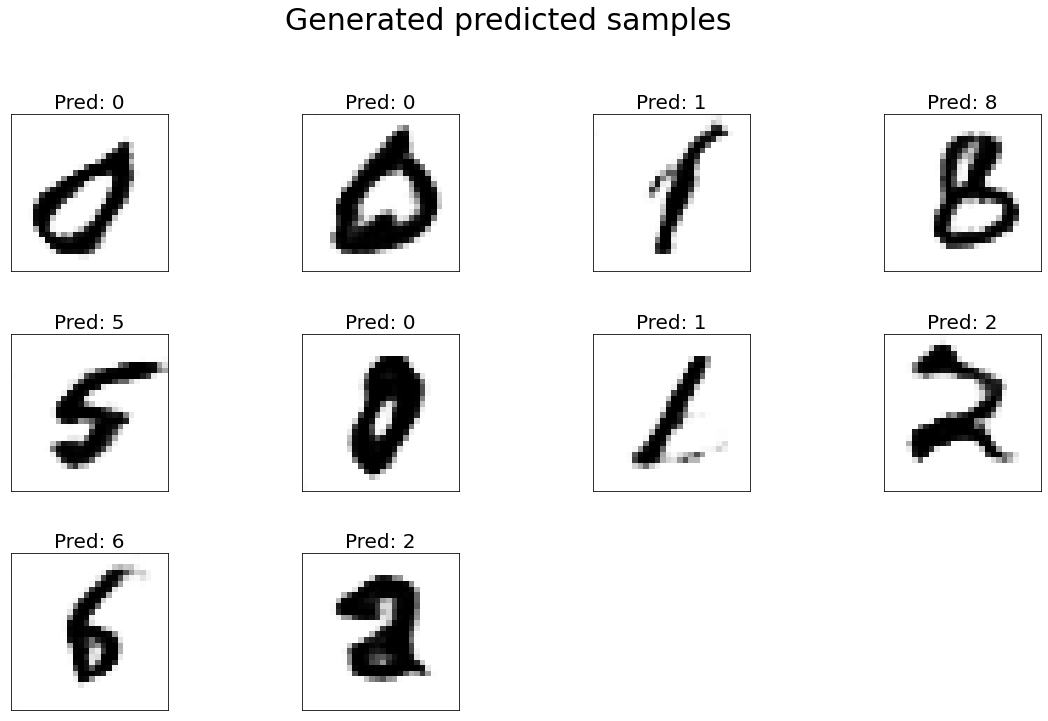

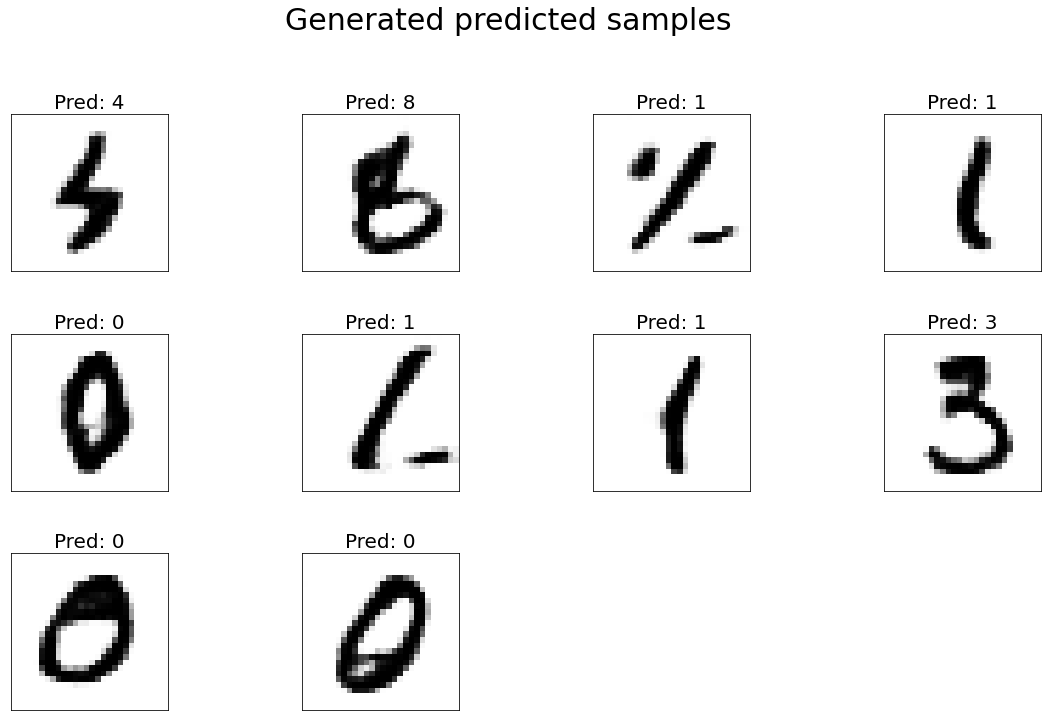

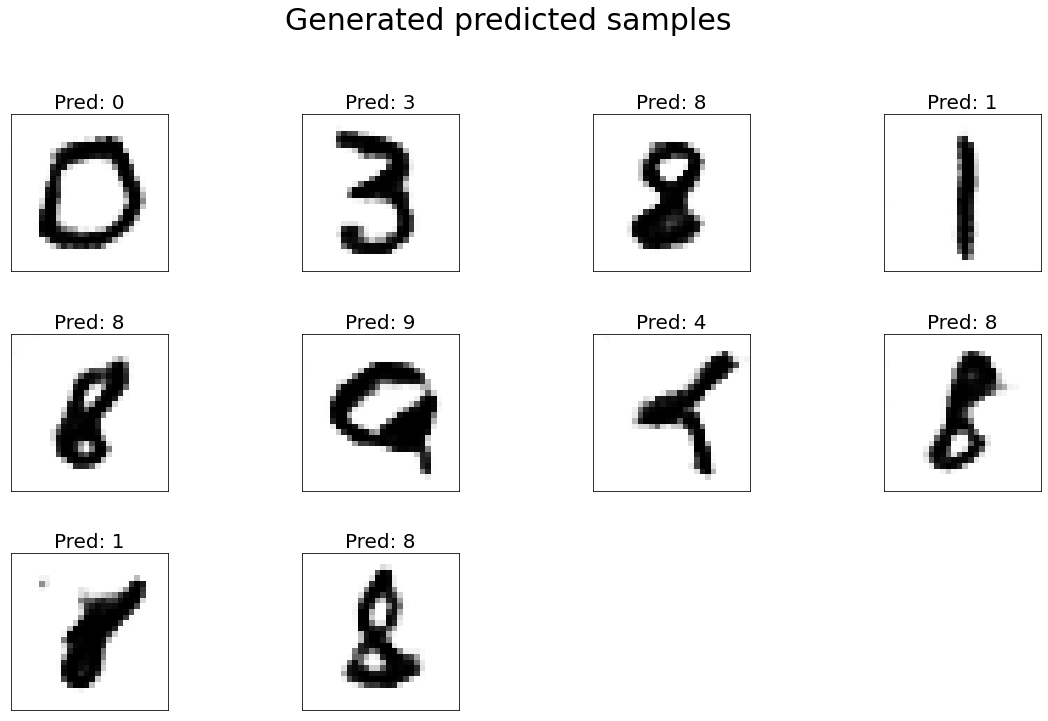

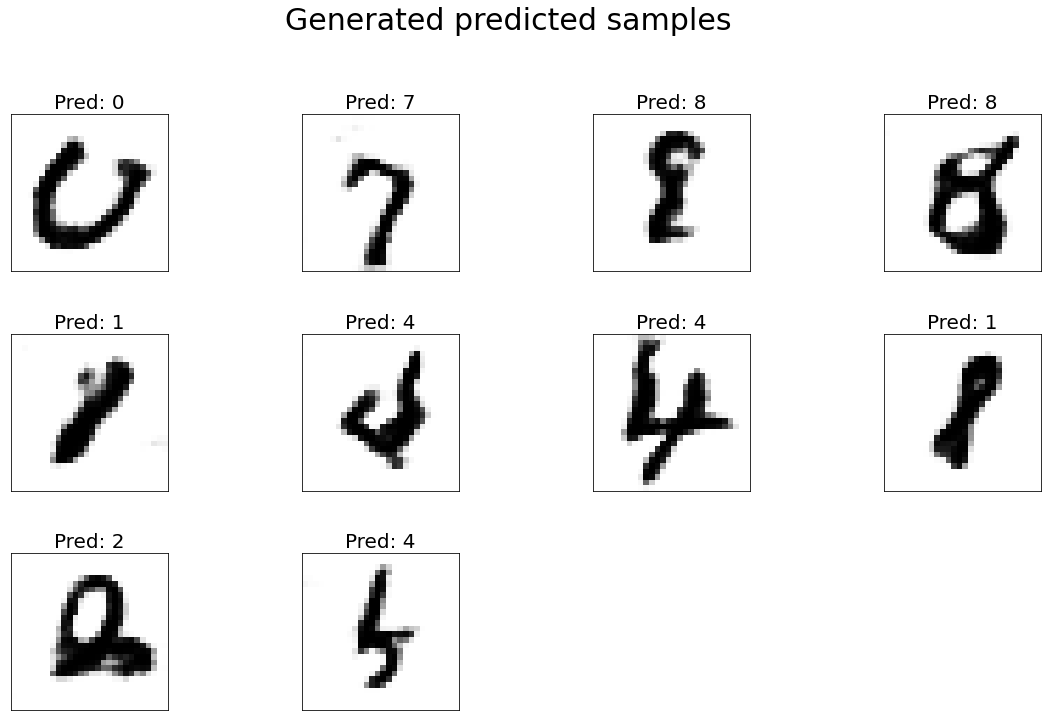

In [132]:

for i in range(len(flist_images)//10):
  gen_im = torch.stack(flist_images[10*i:10*(i+1)])
  pred_lb = torch.tensor(flist_lab[10*i:10*(i+1)])
  showImages(gen_im, generated=1, predicted_labels=pred_lb, predicted=1, epoch=7)
  plt.show()
  if i > 4: break


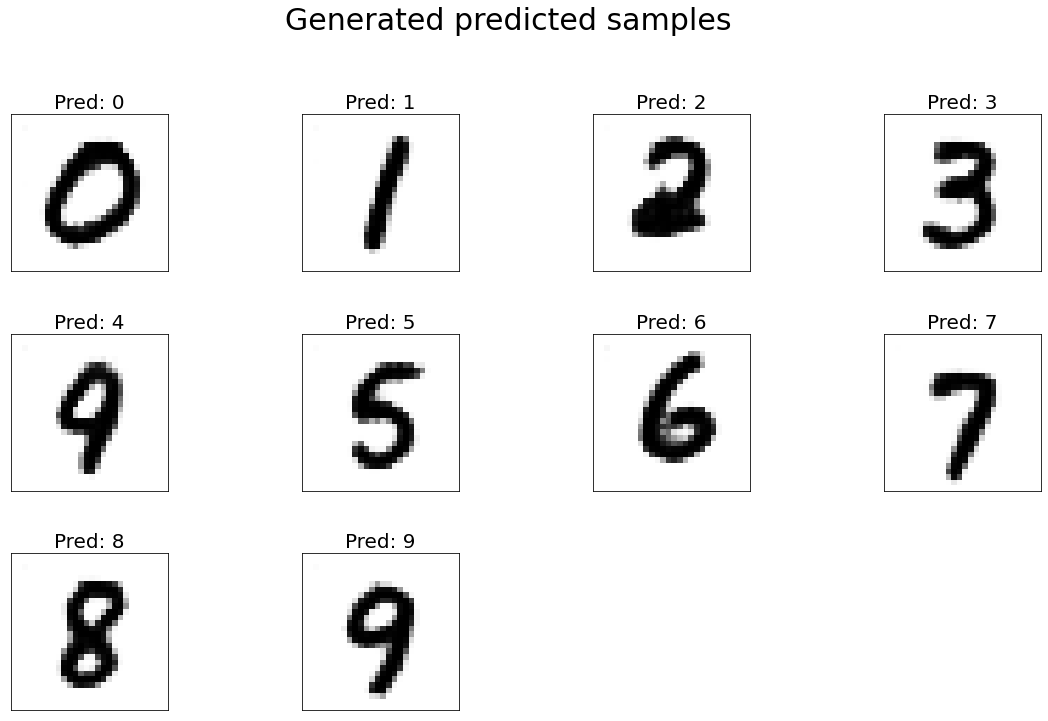

In [147]:
# list_lat_vec = []
# list_lab = []
list_label = [[] for i in range(n_classes)]

for i in range(len(list_lat_vec)):
  lab = cnn.predictLabels(list_lab[i])[0]

  for j in range(len(lab)):
    list_label[lab[j]].append(list_lat_vec[i][j]) #adding each labelled latent vector to its corresponding j class



for i in range(len(list_label)):
  mean = torch.mean(torch.stack(list_label[i]), 0) #calculating the mean of these mean latent vectors
  list_label[i] = mean

list_images = []
a = generator(torch.stack(list_label))
showImages(a, generated = 1, predicted_labels = torch.arange(10), predicted = 1, epoch = 7)
plt.show()



